# Day 31 - Zillow EDA on Missing Values & Multicollinearity

https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity

여기서 다룰 주제
- 결측값 분석
- 상관관계 분석
- 최고 기여 변수 (XGBoost 통해)
- 다중공선성 분석
- 일변량 분석
- 이변량 분석

### Global Imports

In [3]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
%matplotlib inline

### Reading In Dataset

In [4]:
train = pd.read_csv('../input/train_2016_v2.csv', parse_dates=['transactiondate'])
properties = pd.read_csv('../input/properties_2016.csv')

### pd.read_csv의 parse_dates : 날짜 컬럼 datetime 형식으로 불러오기
### 그냥 불러오면 object 데이터타입.

### Shape of The Dataset

In [5]:
print('Shape of Train :', train.shape)
print('Shape of Properties :', properties.shape)

Shape of Train : (90275, 3)
Shape of Properties : (2985217, 58)


### Merge train and properties To Facilitate EDA

In [6]:
merged = pd.merge(train, properties, on='parcelid', how='left')

### First Few Rows of Data

In [7]:
merged.head(3).transpose()   ### data.T와 같은 역할 : 전치

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
airconditioningtypeid,1.0,NaN,1.0
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2.0,3.5,3.0
bedroomcnt,3.0,4.0,2.0
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4.0,NaN,4.0


### Visualizing Datatypes

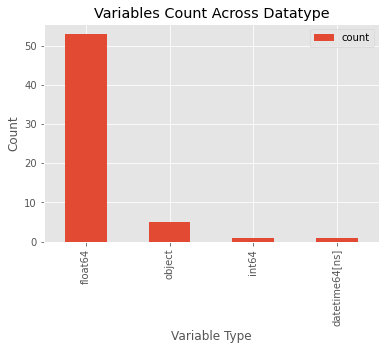

In [24]:
dataTypeDf = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={'index':'variableType', 0:'count'})

#fig, ax = plt.subplots()
#fig.set_size_inches(20,5)
#sn.barplot(data=dataTypeDf, x='variableType', y='count', ax=ax, color='#34495e')
#ax.set(xlabel='Variable Type', ylabel='Count', title='Variables Count Across Datatype')
ax = dataTypeDf.plot(x='variableType', y='count', kind='bar')
ax.set(xlabel='Variable Type', ylabel='Count', title='Variables Count Across Datatype')
plt.show()

### Missing Value Analysis

<AxesSubplot:>

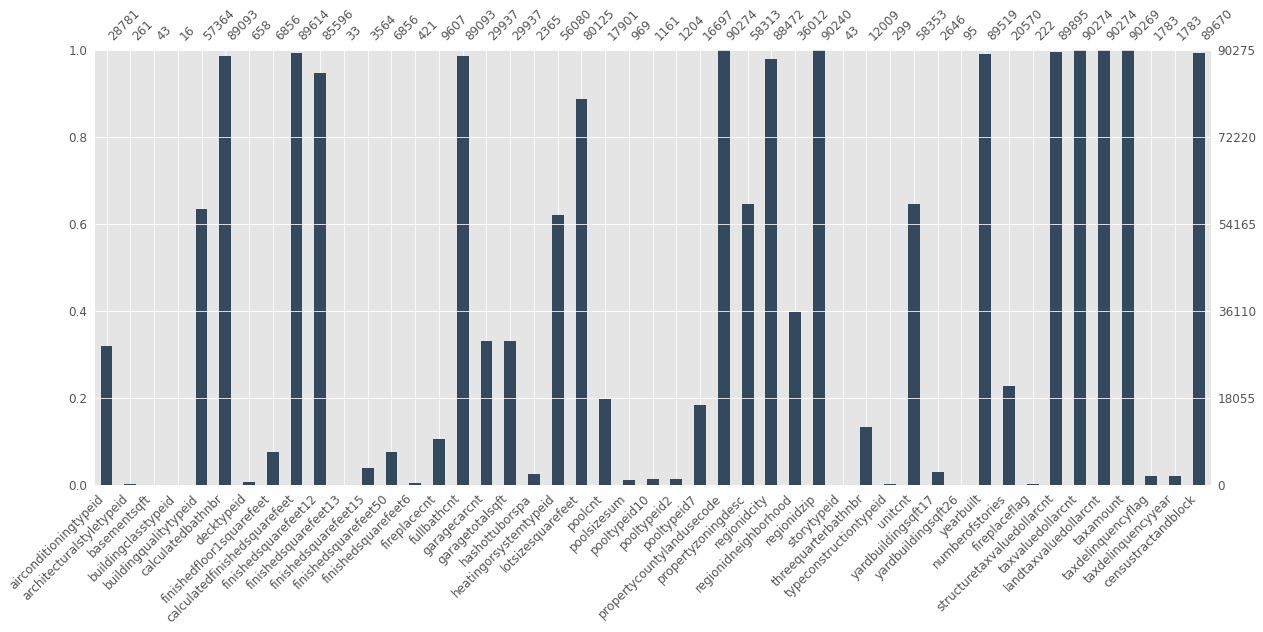

In [25]:
missingValueColumns = merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missingValueColumns], figsize=(20,8),
        color='#34495e', fontsize=12, labels=True)

### merged[listname] : 리스트를 dataframe 형식으로

<AxesSubplot:>

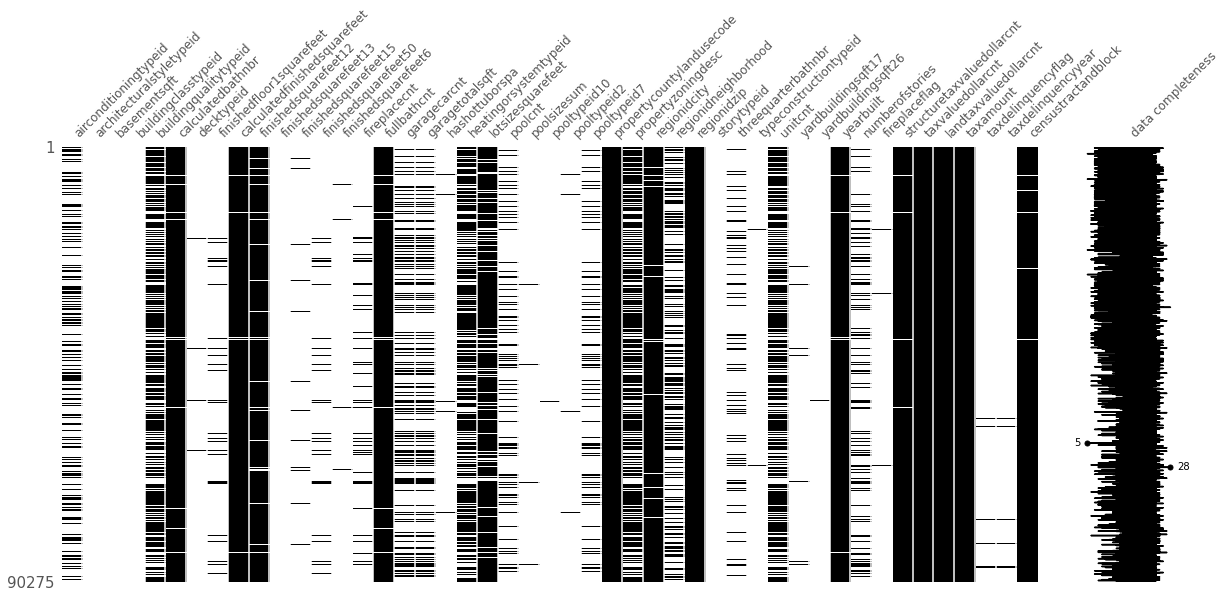

In [32]:
msno.matrix(merged[missingValueColumns], width_ratios=(10,1),
           figsize=(20,8), color=(0,0,0), fontsize=12, sparkline=True, labels=True)

<AxesSubplot:>

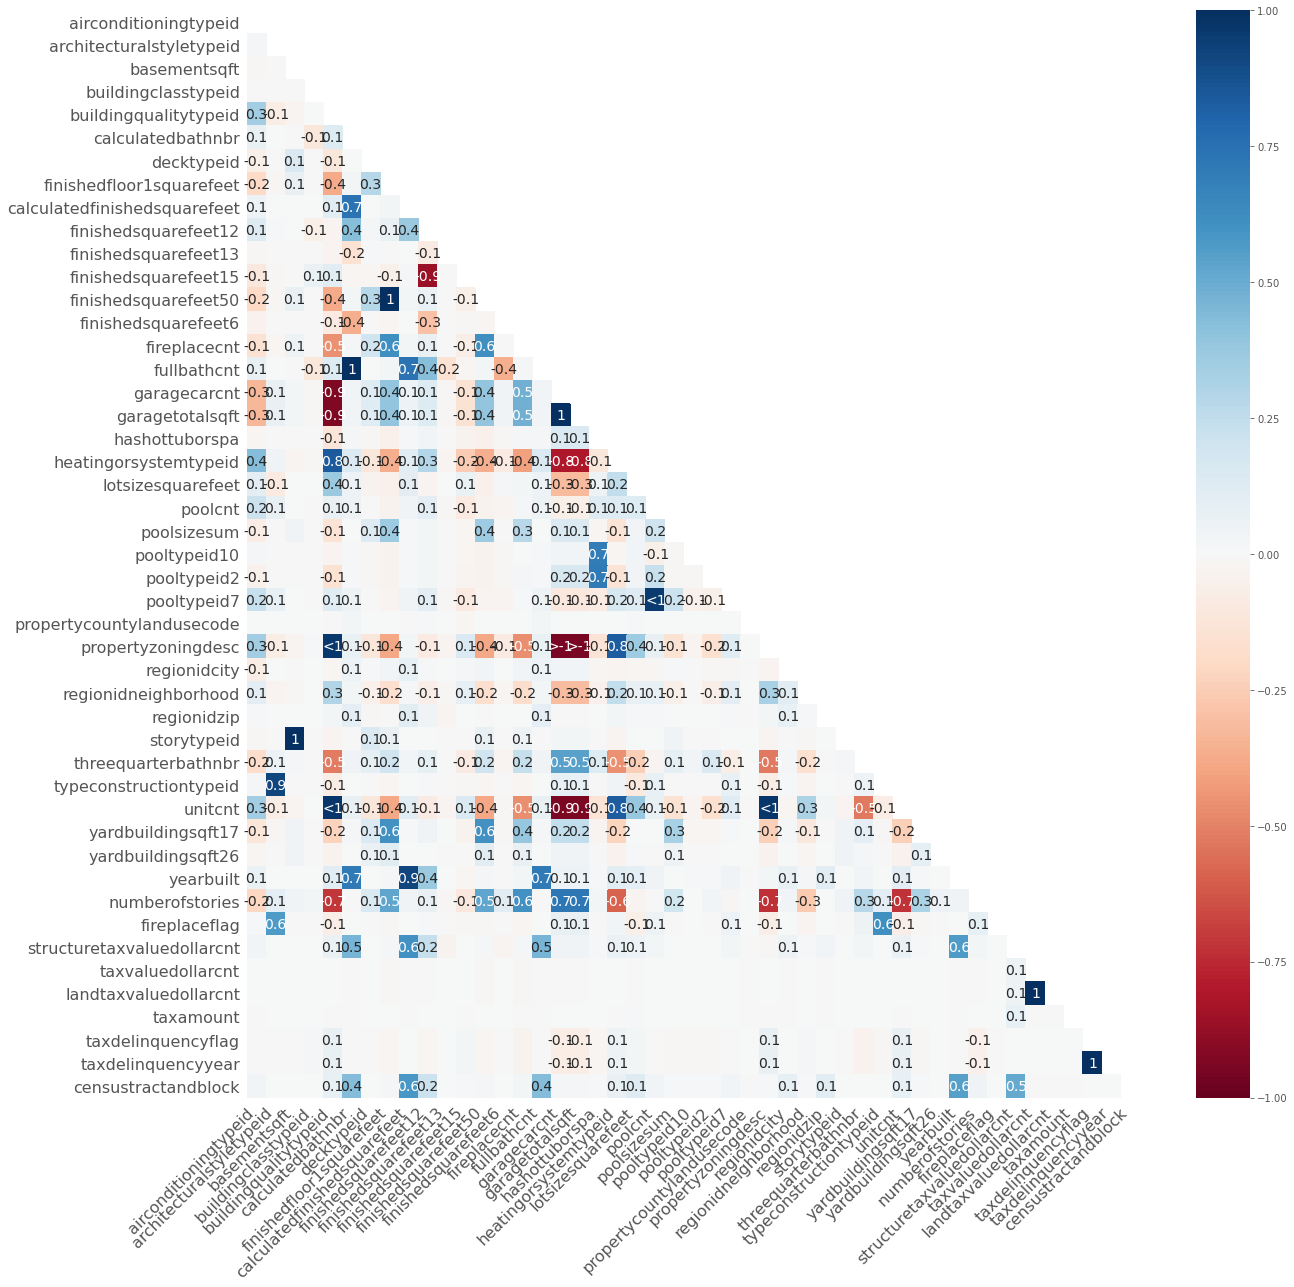

In [33]:
msno.heatmap(merged[missingValueColumns], figsize=(20,20))

### Top Features Selection

In [35]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values))
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))
        
train_y = mergedFilterd.logerror.values
train_X = mergedFilterd.drop(['parcelid','transactiondate','logerror'], axis=1)

xgb_params = {'eta':0.05, 'max_depth':8, 'subsample':0.7, 'colorsmaple_bytree':0.7,
             'object':'reg:linear', 'eval_metric':'rmse','silent':1}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

[15:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colorsmaple_bytree, object, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




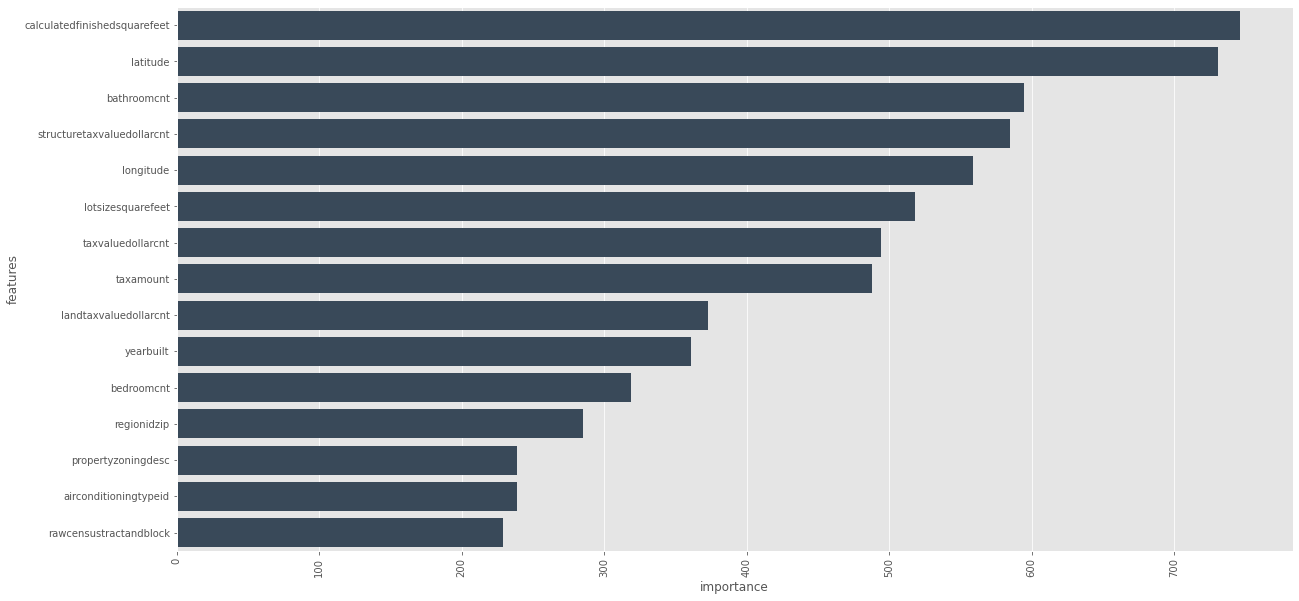

In [37]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'], ascending=False, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(15), x='importance', y='features', ax=ax, orient='h', color='#34495e')
plt.show()

### Correlation Analysis